# Problem 1: support vector machines in Pytorch

In this exercise, you will implement a support vector machine in Pytorch. You will use the CIFAR10 dataset, which is a multiclass classification dataset. You will implement the following steps:

1. Load the CIFAR10 dataset from `torchvision` and select a subset corresponding to two classes to make a binary classification instance.
1. Create a data loader with appropriate parameters.
1. Write the SVM loss function and optimize it with (stochastic) gradient descent.


## Part 1: loading and preprocessing the dataset

In the next code cell, you should load the `CIFAR10` dataset from `torchvision.datasets`. Its interface is similar to `MNIST`, which we have examined in class. Make sure to load both the train and test versions of the dataset, and preprocess the data so that each channel has a mean of $0.250$ and standard deviation of $0.250$ (each image in `CIFAR10` is a color image, so it has 3 channels).


In [30]:
from torchvision.datasets import CIFAR10, FashionMNIST
from torchvision.transforms import Compose
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor

# preprocessing transforms
transform = Compose([
    ToTensor(),  # scale to [0.0, 1.0]
    Normalize(mean=[0.250, 0.250, 0.250], std=[0.250, 0.250, 0.250])
])

train_data = CIFAR10(root='./data', train=True,
                     download=True, transform=transform)
test_data = CIFAR10(root='./data', train=False,
                    download=True, transform=transform)

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Image shape: {train_data[0][0].shape}")
print(f"Number of classes: {len(train_data.classes)}")
print(f"Class names: {train_data.classes}")

Training set size: 50000
Test set size: 10000
Image shape: torch.Size([3, 32, 32])
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Part 2: data-loaders

In the next cell, you should create data loaders for the train and test datasets. Specifically:

- Create a `torch.utils.data.Subset` that only holds the train and test samples corresponding to classes `6` and `7`.
- Create a 70% / 30% train-validation split from the original training set.
- Create a data loader for the train, validation, and test sets. Use a batch size of 64 for the training set and any batch size you want for the validation and test sets.

> **Hint 1**: If your dataset is stored in a variable called `train_data`, the field containing the class label can be accessed using `train_data.targets`.

> **Hint 2**: Use `torch.utils.data.random_split`.


In [31]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.data import random_split

# filter for classes 6 and 7 only
train_indices = [i for i, label in enumerate(
    train_data.targets) if label in [6, 7]]
test_indices = [i for i, label in enumerate(
    test_data.targets) if label in [6, 7]]

# create binary subsets
train_binary = Subset(train_data, train_indices)
test_binary = Subset(test_data, test_indices)

# 70/30 train-validation split
train_size = int(0.7 * len(train_binary))
val_size = len(train_binary) - train_size
train_subset, val_subset = random_split(train_binary, [train_size, val_size])

# data loaders for batching
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_binary, batch_size=128, shuffle=False)

In the following cell, we define a simple SVM model for the CIFAR-10 dataset. The inputs are batches of $32 \times 32$ images with 3 channels, while the output should be a real number for each image. This is the model that we will train later.


In [32]:
import torch.nn as nn


class SimpleSVM(nn.Module):
    def __init__(self, num_channels: int, pixel_size: int):
        super(SimpleSVM, self).__init__()
        self.fc = nn.Linear(pixel_size * pixel_size * num_channels, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x).flatten()

## Part 3: loss function

In the next cell, you will create the loss function. In class, we looked at the following formulation for SVMs with non-separable data:

$$
\begin{aligned}
\min_{w, b, \xi} \quad &\frac{1}{2} \|w\|^2 + C \cdot \frac{1}{n} \sum_{i = 1}^{n} \max(\xi_{i}, 0) \\
\text{s.t.} \quad & y^{(i)} \cdot (w^{\mathsf{T}} x^{(i)} + b) \geq 1 - \xi_{i}, \;\; \text{for $i = 1, \dots, n$,}
\end{aligned}
$$

where $x^{(i)}$ are the features and $y^{(i)} \in \{-1, 1\}$ are the class labels.

We will implement the _unconstrained_ version of this loss, which eliminates the slack variables $\{\xi_{i}\}_{i = 1}^n$:

$$
\min_{w, b} \frac{1}{2} \|w\|^2 + C \cdot \frac{1}{n} \sum_{i = 1}^{n}
\max(0, 1 - y^{(i)} \cdot (w^{\mathsf{T}} x^{(i)} + b)).
$$

In the code cell below, create a `torch.nn.Module` subclass, accepting a parameter `C`, whose `forward` method has the following signature:

```python
class SVMLoss(...):

  ...

  def forward(self, prediction, target):
    ...
```

and computes the following output:

$$
C \cdot \frac{1}{n} \sum_{i = 1}^{n} \max(0, 1 - y_{i} \cdot \widehat{y}_{i}),
$$

where $y$ is the variable `target` and $\widehat{y}$ is the variable `prediction`. You can assume that these variables are `torch` vectors in $\mathbb{R}^n$.

> **Hint**: you do _not_ need to know the value of $n$ in advance to implement this (see `torch.mean`).

> **Hint**: You can use the `torch.relu` function to compute the positive part of a tensor.


In [33]:
import torch
import torch.nn as nn


class SVMLoss(nn.Module):
    def __init__(self, C: float):
        super(SVMLoss, self).__init__()
        self.C = C

    def forward(self, prediction, target):
        loss = torch.relu(1 - target * prediction)
        return self.C * torch.mean(loss)

## Part 4: optimization

In the next cell, create an SVM model with the appropriate input size, instantiate the SGD optimizer with weight decay parameter $\frac{1}{2}$ and learning rate $\frac{1}{10}$, and train the SVM model with $C = 1$ for 50 epochs, keeping track of the training and validation error and accuracy. Plot the resulting metrics as a function of the number of epochs, and report the final accuracy on the test set.

Is the model underfitting, overfitting, or just right?

### Some tips

When consuming the dataset, make sure to convert the class label `6` to `-1` and `7` to `1`, since the SVM is a binary classifier. This can be accomplished using the following code:

```python
labels = torch.where(labels == 6, -1, 1)
```

You can also use the following code to convert the output of the SVM to a class label:

```python
labels = torch.where(outputs > 0, 1, -1)
```


In [34]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


@torch.no_grad()
def convert_labels(labels: torch.Tensor) -> torch.Tensor:
    labels = torch.where(labels == 6, -1, 1)
    return labels


@torch.no_grad()
def convert_output(predictions: torch.Tensor) -> torch.Tensor:
    predictions = torch.where(predictions > 0, 1, -1)
    return predictions


@torch.no_grad()
def compute_loss(
    model: nn.Module, loss_fn: nn.Module, dataloader: DataLoader
) -> float:
    """Compute a given loss on an entire dataset.

    Args:
        model: The model to compute the loss on.
        loss_fn: The loss function to use.
        dataloader: The dataloader to compute the loss on.

    Returns:
        The loss averaged over the dataset.
    """
    loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for features, labels in dataloader:
            # Make labels -1 or 1
            labels = convert_labels(labels)
            outputs = model(features)
            loss += loss_fn(outputs, labels).item()
            total_samples += labels.size(0)
    return loss / total_samples


@torch.no_grad()
def compute_accuracy(model: nn.Module, dataloader: DataLoader) -> float:
    """Compute the accuracy of a model on a binary classification dataset.

    Args:
        model: The model to compute the accuracy for.
        dataloader: The dataloader to compute the accuracy on.

    Returns:
        The accuracy of the model on the dataset.
    """
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in dataloader:
            # Make labels -1 or 1
            labels = convert_labels(labels)
            outputs = model(features)
            # Make output -1 or 1
            outputs = convert_output(outputs)
            correct += (outputs == labels).float().sum().item()
            total += labels.size(0)
    return correct / total

In [35]:
import torch
import torch.optim as optim

# initialize model, loss function, and optimizer
model = SimpleSVM(num_channels=3, pixel_size=32)
loss_fn = SVMLoss(C=1.0)
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.5)

# training loop parameters
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0

    for batch_idx, (features, labels) in enumerate(train_loader):
        labels = convert_labels(labels)

        # forward pass
        optimizer.zero_grad()
        outputs = model(features)
        loss = loss_fn(outputs, labels)

        # backward pass
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)

    # gather evaluation metrics
    model.eval()
    val_loss = compute_loss(model, loss_fn, val_loader)
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)

    # store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

test_accuracy = compute_accuracy(model, test_loader)
print(f'Final Test Accuracy: {test_accuracy:.4f}')

Epoch [10/50], Train Loss: 18.9566, Val Loss: 0.1352, Train Acc: 0.5123, Val Acc: 0.5100
Epoch [20/50], Train Loss: 17.9620, Val Loss: 0.1419, Train Acc: 0.4934, Val Acc: 0.5003
Epoch [30/50], Train Loss: 18.9086, Val Loss: 0.2967, Train Acc: 0.5679, Val Acc: 0.5577
Epoch [40/50], Train Loss: 19.1157, Val Loss: 0.1580, Train Acc: 0.5269, Val Acc: 0.5273
Epoch [50/50], Train Loss: 18.5954, Val Loss: 0.1202, Train Acc: 0.6036, Val Acc: 0.6060
Final Test Accuracy: 0.6080


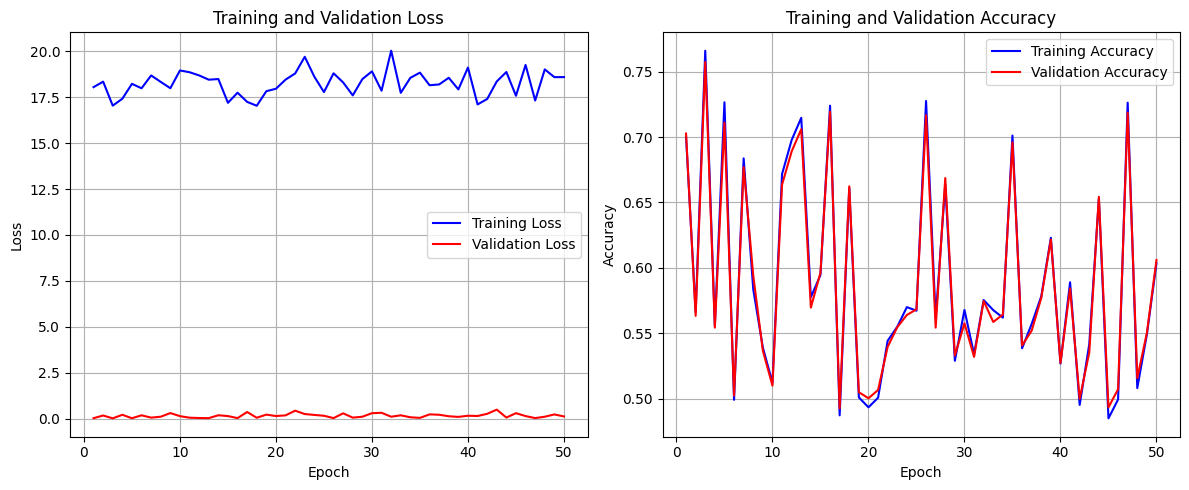

Final Training Accuracy: 0.6036
Final Validation Accuracy: 0.6060
Final Test Accuracy: 0.6080


In [36]:
import matplotlib.pyplot as plt

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# plot losses
epochs = range(1, num_epochs + 1)
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# plot accuracies
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Based on the plots, the model seems to be underfitting as both the training and validation accuracies are poor (~60%), and training loss remains high without any significant decrease over epochs. The accuracy curves are also noisy and don't show any clear upward trend, indicating that the model is not learning effectively from the data.


## Part 5 (extra credit)

Can you further improve the classification accuracy further, by suitable tweaks to model or architectural hyperparameters? Add a code cell implementing your improvement. For every improvement / tweak, provide a short justification of why you chose it and why it works.


In [38]:
class ImprovedSVM(nn.Module):
    def __init__(self, num_channels: int, pixel_size: int):
        super(ImprovedSVM, self).__init__()
        input_size = pixel_size * pixel_size * num_channels
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x).flatten()


# initialize improved model, loss function, and optimizer
improved_model = ImprovedSVM(num_channels=3, pixel_size=32)
improved_loss_fn = SVMLoss(C=0.1)  # reduced C
improved_optimizer = optim.SGD(
    improved_model.parameters(),
    lr=0.01,  # reduced learning rate
    weight_decay=0.01,  # lowered weight decay
    momentum=0.9  # added momentum for smoother convergence
)

# training loop for improved model
num_epochs = 50
improved_train_losses = []
improved_val_losses = []
improved_train_accuracies = []
improved_val_accuracies = []

for epoch in range(num_epochs):
    improved_model.train()
    epoch_train_loss = 0.0

    for batch_idx, (features, labels) in enumerate(train_loader):
        labels = convert_labels(labels)

        improved_optimizer.zero_grad()
        outputs = improved_model(features)
        loss = improved_loss_fn(outputs, labels)

        loss.backward()
        improved_optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)

    # gather evaluation metrics
    improved_model.eval()
    val_loss = compute_loss(improved_model, improved_loss_fn, val_loader)
    train_acc = compute_accuracy(improved_model, train_loader)
    val_acc = compute_accuracy(improved_model, val_loader)

    # store metrics
    improved_train_losses.append(avg_train_loss)
    improved_val_losses.append(val_loss)
    improved_train_accuracies.append(train_acc)
    improved_val_accuracies.append(val_acc)

    # print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        current_lr = improved_optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{num_epochs}], LR: {current_lr:.4f}, '
              f'Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

improved_test_accuracy = compute_accuracy(improved_model, test_loader)
print(f'Original Model Test Accuracy: {test_accuracy:.4f}')
print(f'Improved Model Test Accuracy: {improved_test_accuracy:.4f}')

Epoch [10/50], LR: 0.0100, Train Loss: 0.0428, Val Loss: 0.0004, Train Acc: 0.8517, Val Acc: 0.8177
Epoch [20/50], LR: 0.0100, Train Loss: 0.0411, Val Loss: 0.0004, Train Acc: 0.8304, Val Acc: 0.8057
Epoch [30/50], LR: 0.0100, Train Loss: 0.0415, Val Loss: 0.0005, Train Acc: 0.7994, Val Acc: 0.7703
Epoch [40/50], LR: 0.0100, Train Loss: 0.0433, Val Loss: 0.0004, Train Acc: 0.8474, Val Acc: 0.8113
Epoch [50/50], LR: 0.0100, Train Loss: 0.0431, Val Loss: 0.0004, Train Acc: 0.8534, Val Acc: 0.8230
Original Model Test Accuracy: 0.6080
Improved Model Test Accuracy: 0.8335


The hyperparameter tweaks I made resulted in a significant accuracy boost from ~60% to ~83%. I reduced the learning rate to 0.01 to provide more stable gradient updates and prevent the optimizer from overshooting. I noticed that the weight decay was too high, which likely prevented the model from learning meaningful patterns, so I reduced it to 0.01. Adding a momentum value as 0.9 helped accelerate convergence and smooth out any noisy gradients as well. Finally, I reduced the SVM regularization parameter C to 0.1 to allow for a softer margin, which allowed the model to generalize better on the validation set. These combined changes led to a more effective training process and improved overall performance.


# Problem 2: data compression with autoencoders

Autoencoders are neural networks whose goal is to compress data by finding a succinct, lower-dimensional representation akin to the one found by PCA. In this exercise, you will implement an autoencoder to compress data from the CIFAR10 dataset. Note that the data compression problem is unsupervised, so you will not need to use the labels.


## Part 1: loading and preprocessing the data

Create suitable dataloaders for the training and test sets, as well as a 70% / 30% train / validation split. Do _not_ normalize the data; each pixel should have values in `[0, 1]`, and normalization can violate this.


In [13]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

transform = ToTensor()
train_data = CIFAR10(root='./data', train=True,
                     download=True, transform=transform)
test_data = CIFAR10(root='./data', train=False,
                    download=True, transform=transform)

train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size
train_subset, val_subset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(test_data)}")
print(f"Image shape: {train_data[0][0].shape}")

Training set size: 35000
Validation set size: 15000
Test set size: 10000
Image shape: torch.Size([3, 32, 32])


## Part 2: standard autoencoder model

Autoencoders comprise two parts: namely, an encoder and a decoder, each of which is implemented as a neural network.

Encoders typically map high-dimensional inputs to a lower-dimensional space, while decoders map the lower-dimensional space back to the original space. The standard implementation works as follows:

1. The encoder takes an input $x$ and maps it to a lower-dimensional space $z$.
2. The decoder takes the lower-dimensional space $z$ and maps it back to the original space $x$.
3. The loss is computed as the mean-squared error between the original input $x$ and the decoded output $\hat{x}$.

In the code cell below, create an autoencoder model with the following specifications:

- The encoder should have 2 fully connected layers of size 128 and 32, respectively.
- The decoder should have 2 fully connected layers of size 32 and 128, respectively.
- Each layer (except for the very last one) should use the ReLU activation function.
- The last layer should not use any activation function.
- The input and output should have the same shape, comprising images of size $3 \times 32 \times 32$.


In [ ]:
import torch.nn as nn
import torch


# @torch.compile
# I got an InductorError: clang++: error: no such file or directory: '344/hw3/.venv/lib/python3.13/site-packages/torch/lib'
# while using the decorator on python 3.13.7 and got a RuntimeError when using with python 3.14+
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim: int = 32):
        super(AutoEncoder, self).__init__()

        input_size = 3 * 32 * 32  # 3072

        # encode 3072 -> 128 -> 32
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )

        # decode 32 -> 128 -> 3072
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
        )

    def forward(self, x):
        # (batch_size, 3, 32, 32) -> (batch_size, 3072)
        batch_size = x.size(0)

        x_flat = x.view(batch_size, -1)

        z = self.encoder(x_flat)
        x_reconstructed = self.decoder(z)

        # (batch_size, 3072) -> (batch_size, 3, 32, 32)
        x_reconstructed = x_reconstructed.view(batch_size, 3, 32, 32)
        return x_reconstructed

## Part 3: training the autoencoder

In the following code cell, train the autoencoder for 100 epochs using the mean-squared reconstruction error as the loss function. You are free to use any optimizer, learning rate, and other hyperparameters such as weight decay or batch size as you deem appropriate. You can also use other techniques like early stopping, batch normalization, or dropout during training. You can start with the default values of:

- optimizer: `torch.optim.SGD` with learning rate 0.01
- batch size: 128
- no weight decay or early stopping
- no dropout batch normalization

You should turn in both a code cell implementing the training as well as a plot of training and validation loss as a function of epochs. Is your model underfitting, overfitting, or just right?

> **Hint**: You can adapt the `compute_loss` function from Problem 1 to calculate the MSE loss on the validation set at the end of each epoch. Make sure you change it so that it computes the MSE between original and reconstructed images.


Epoch [10/100], Train Loss: 0.015147, Val Loss: 0.015079
Epoch [20/100], Train Loss: 0.015044, Val Loss: 0.014928
Epoch [30/100], Train Loss: 0.014969, Val Loss: 0.014953
Epoch [40/100], Train Loss: 0.014915, Val Loss: 0.014873
Epoch [50/100], Train Loss: 0.014876, Val Loss: 0.014870
Epoch [60/100], Train Loss: 0.014844, Val Loss: 0.014841
Epoch [70/100], Train Loss: 0.014820, Val Loss: 0.014836
Epoch [80/100], Train Loss: 0.014811, Val Loss: 0.014784
Epoch [90/100], Train Loss: 0.014773, Val Loss: 0.014786
Epoch [100/100], Train Loss: 0.014756, Val Loss: 0.014777

Total Training Time: 286.06 seconds


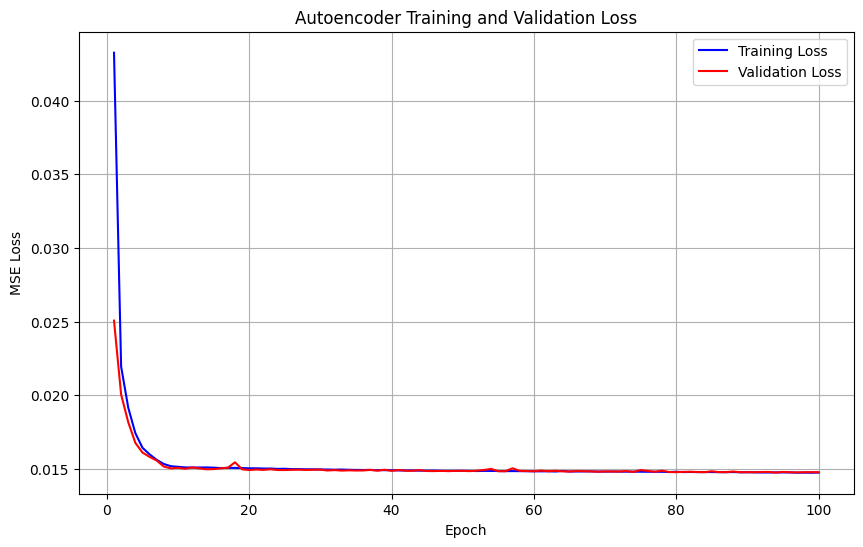


Final Training Loss: 0.014756
Final Validation Loss: 0.014777


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


@torch.no_grad()
def compute_autoencoder_loss(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0.0
    total_samples = 0

    for features, _ in dataloader:
        reconstructed = model(features)
        loss = loss_fn(reconstructed, features).item()
        total_loss += loss * features.size(0)
        total_samples += features.size(0)

    return total_loss / total_samples


# initialize model, loss function, and optimizer
autoencoder = AutoEncoder(latent_dim=32)
mse_loss = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# training parameters
num_epochs = 100
train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(num_epochs):
    autoencoder.train()
    epoch_train_loss = 0.0
    num_train_samples = 0

    for features, _ in train_loader:
        # forward
        optimizer.zero_grad()
        reconstructed = autoencoder(features)
        loss = mse_loss(reconstructed, features)

        # backward
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * features.size(0)
        num_train_samples += features.size(0)

    # gather metrics
    avg_train_loss = epoch_train_loss / num_train_samples
    val_loss = compute_autoencoder_loss(autoencoder, mse_loss, val_loader)

    # store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)

    # print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(
            f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}')

training_time = time.time() - start_time
print(f"\nTotal Training Time: {training_time:.2f} seconds")

# training and validation loss plot
plt.figure(figsize=(10, 6))
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")

Based on the plot, the autoencoder model appears to be well fitted, as the training and validation loss curves track closely together, indicating that the model is learning effectively without overfitting. Both losses converge and the final loss values of ~0.014 are pretty good as well.


## Part 4: plotting

For the model you trained in Part 3, do the following:

- Select 3 random images from the validation set;
- Pass them through the model and obtain their reconstructions;
- Plot the original images and their reconstructions side by side (e.g. on a 3x2 grid).

Then use your plots to answer the following questions:

- Do you observe anything common among the image reconstructions?
- How do you expect the reconstruction quality to change as you increase the size of the latent space?

---

To plot a single image of size (3, 32, 32) (i.e., 3 channels), you can use the following command:

```python
plt.imshow(image.permute(1, 2, 0))
```

This is because `pytorch` uses image channels first, while `matplotlib` uses channels last.


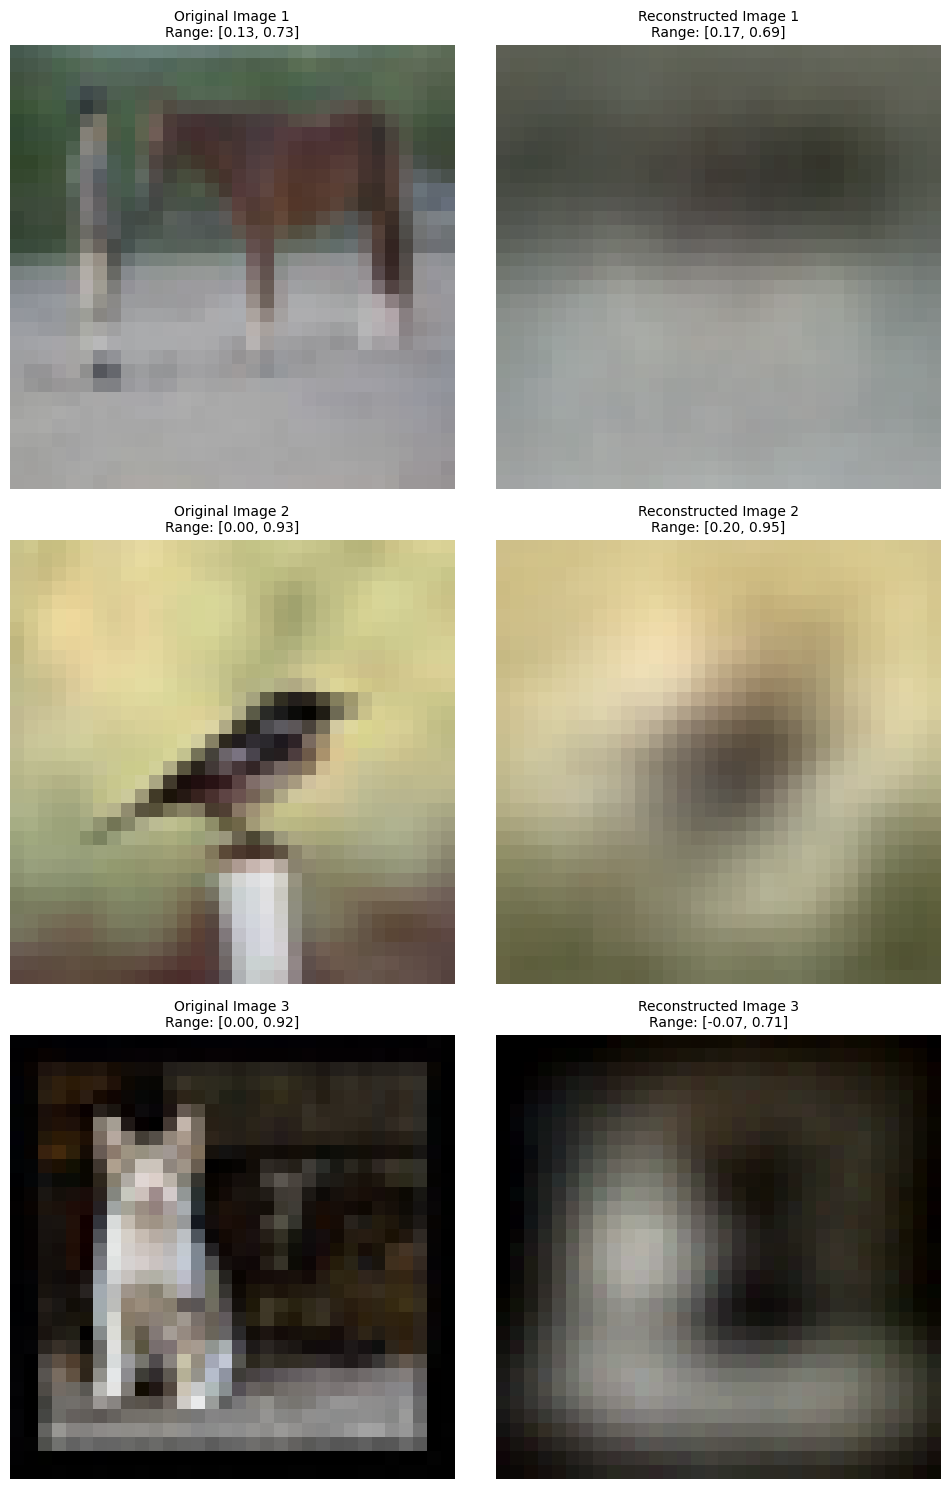

In [ ]:
import matplotlib.pyplot as plt
import torch
import random

# select 3 random indices from validation set
val_indices = list(range(len(val_subset)))
random_indices = random.sample(val_indices, 3)

# original images
images = []
for idx in random_indices:
    img, _ = val_subset[idx]
    images.append(img)

images_batch = torch.stack(images)

# reconstructions from the model
autoencoder.eval()
with torch.no_grad():
    reconstructions = autoencoder(images_batch)

for i in range(3):
    mse = ((images[i] - reconstructions[i]) ** 2).mean().item()

# create subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    orig_img = images[i].permute(1, 2, 0).cpu().numpy()
    axes[i, 0].imshow(orig_img.clip(0, 1))
    axes[i, 0].set_title(
        f'Original Image {i+1}\nRange: [{orig_img.min():.2f}, {orig_img.max():.2f}]', fontsize=10)
    axes[i, 0].axis('off')

    recon_img = reconstructions[i].permute(1, 2, 0).cpu().numpy()
    axes[i, 1].imshow(recon_img.clip(0, 1))
    axes[i, 1].set_title(
        f'Reconstructed Image {i+1}\nRange: [{recon_img.min():.2f}, {recon_img.max():.2f}]', fontsize=10)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

> Do you observe anything common among the image reconstructions?

The reconstructions are blurry and lack fine details compared to the originals. They capture the general color palette and overall structure (e.g., animals, backgrounds) but lose sharp edges, which is expected because the 32-dimensional latent space is a significant compression from 3072 dimensions.

> How do you expect reconstruction quality to change as you increase the latent space size?

As the latent space size increases, reconstruction quality should improve with sharper details and better preservation of fine features. A larger latent space can encode more information. However, the improvement will plateau at some point and an excessively large latent space may lead to overfitting.


## Part 5: weight tying

One way to improve the performance of autoencoders is to "force" the decoder to look like a mirror image of the encoder. In other words, if the encoder computes (for a fixed activation function $\sigma$):

$$
\mathrm{Enc}(x) = \sigma(W_{2} \sigma(W_{1} x)),
$$

then the decoder should compute its mirror image:

$$
\mathrm{Dec}(z) = W_{1}^{\mathsf{T}} \sigma(W_{2}^{\mathsf{T}} z)).
$$

Implement this change in your model from Part 2 and repeat the experiment from Part 3. Then answer the following questions:

- Is the reconstruction quality better, worse, or roughly the same?
- If you use the same hyperparameters to train this model and the model from Part 2, is training faster or slower?
- Is this model more or less likely to overfit than the model from Part 2, and why?

For this part, you should turn in both a code cell implementing the model, training and any necessary plots to answer the above questions, as well as a text cell containing your answers to each question.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class TransposedAutoEncoder(nn.Module):
    def __init__(self, latent_dim: int = 32):
        super().__init__()

        input_size = 3 * 32 * 32  # 3072

        # encoder layers with only weight matrices
        self.enc_fc1 = nn.Linear(input_size, 128)
        self.enc_fc2 = nn.Linear(128, latent_dim)

        # decoder layers using transposed weights
        self.dec_fc1_bias = nn.Parameter(torch.zeros(128))
        self.dec_fc2_bias = nn.Parameter(torch.zeros(input_size))

    def forward(self, x):
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)

        # encoder
        z = F.relu(self.enc_fc1(x_flat))
        z = self.enc_fc2(z)

        # decoder
        x_recon = F.linear(z, self.enc_fc2.weight.t(), self.dec_fc1_bias)
        x_recon = F.relu(x_recon)
        x_recon = F.linear(x_recon, self.enc_fc1.weight.t(), self.dec_fc2_bias)

        x_recon = x_recon.view(batch_size, 3, 32, 32)
        return x_recon

Training:  10%|█         | 10/100 [00:26<03:52,  2.58s/it]

Epoch [10/100], Train Loss: 0.012851, Val Loss: 0.012781


Training:  20%|██        | 20/100 [00:51<03:26,  2.58s/it]

Epoch [20/100], Train Loss: 0.012764, Val Loss: 0.012692


Training:  30%|███       | 30/100 [01:17<03:00,  2.57s/it]

Epoch [30/100], Train Loss: 0.012695, Val Loss: 0.012677


Training:  40%|████      | 40/100 [01:43<02:33,  2.56s/it]

Epoch [40/100], Train Loss: 0.012634, Val Loss: 0.012612


Training:  50%|█████     | 50/100 [02:09<02:09,  2.58s/it]

Epoch [50/100], Train Loss: 0.012602, Val Loss: 0.012582


Training:  60%|██████    | 60/100 [02:34<01:42,  2.57s/it]

Epoch [60/100], Train Loss: 0.012549, Val Loss: 0.012524


Training:  70%|███████   | 70/100 [03:00<01:17,  2.59s/it]

Epoch [70/100], Train Loss: 0.012494, Val Loss: 0.012480


Training:  80%|████████  | 80/100 [03:26<00:51,  2.56s/it]

Epoch [80/100], Train Loss: 0.012459, Val Loss: 0.012456


Training:  90%|█████████ | 90/100 [03:52<00:25,  2.59s/it]

Epoch [90/100], Train Loss: 0.012425, Val Loss: 0.012453


Training: 100%|██████████| 100/100 [04:17<00:00,  2.58s/it]

Epoch [100/100], Train Loss: 0.012391, Val Loss: 0.012414
Standard Autoencoder:
  Final Training Loss: 0.014776
  Final Validation Loss: 0.014774

Weight-Tied Autoencoder:
  Final Training Loss: 0.012391
  Final Validation Loss: 0.012414
  Training Time: 257.80 seconds

Parameter Count:
  Standard: 797,984 parameters
  Weight-Tied: 400,672 parameters


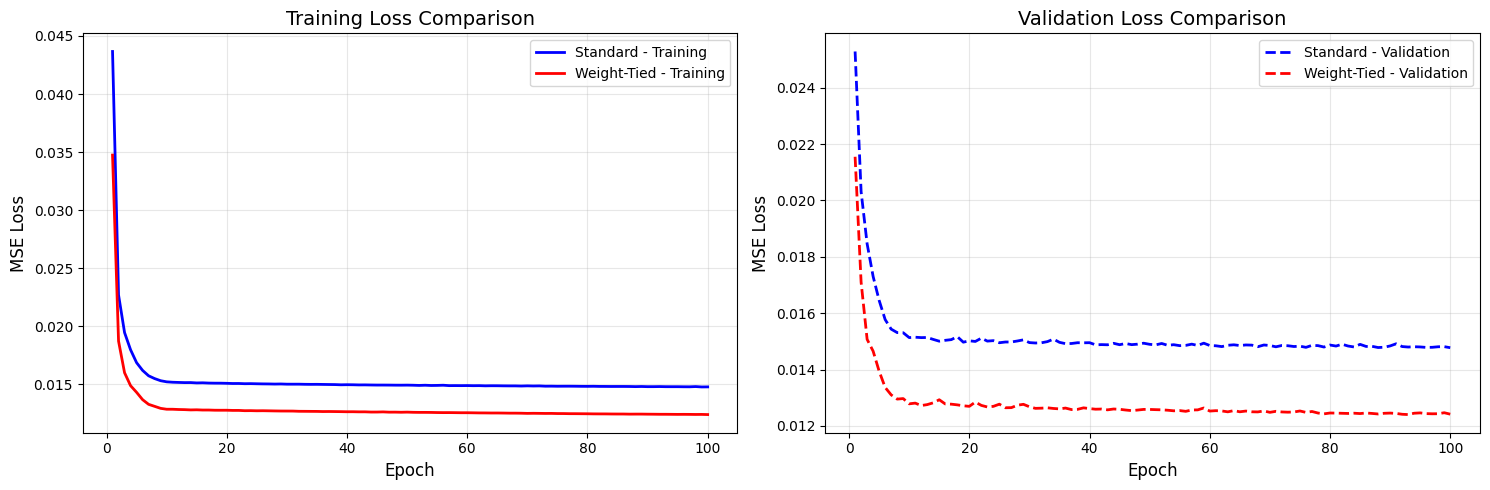

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

# initialize model, loss function, and optimizer
transposed_autoencoder = TransposedAutoEncoder(latent_dim=32)
mse_loss = nn.MSELoss()
optimizer_transposed = optim.Adam(transposed_autoencoder.parameters(), lr=0.001)

# training parameters
num_epochs = 100
transposed_train_losses = []
transposed_val_losses = []

start_time = time.time()

for epoch in tqdm(range(num_epochs), desc="Training"):
    transposed_autoencoder.train()
    epoch_train_loss = 0.0
    num_train_samples = 0

    for features, _ in train_loader:
        optimizer_transposed.zero_grad()
        reconstructed = transposed_autoencoder(features)
        loss = mse_loss(reconstructed, features)

        loss.backward()
        optimizer_transposed.step()

        epoch_train_loss += loss.item() * features.size(0)
        num_train_samples += features.size(0)

    avg_train_loss = epoch_train_loss / num_train_samples
    val_loss = compute_autoencoder_loss(
        transposed_autoencoder, mse_loss, val_loader)

    transposed_train_losses.append(avg_train_loss)
    transposed_val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(
            f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}')

training_time = time.time() - start_time

print(f"Standard Autoencoder:")
print(f"  Final Training Loss: {train_losses[-1]:.6f}")
print(f"  Final Validation Loss: {val_losses[-1]:.6f}")
print()
print(f"Weight-Tied Autoencoder:")
print(f"  Final Training Loss: {transposed_train_losses[-1]:.6f}")
print(f"  Final Validation Loss: {transposed_val_losses[-1]:.6f}")
print(f"  Training Time: {training_time:.2f} seconds")
print()

# count parameters
standard_params = sum(p.numel() for p in autoencoder.parameters())
transposed_params = sum(p.numel() for p in transposed_autoencoder.parameters())
print(f"Parameter Count:")
print(f"  Standard: {standard_params:,} parameters")
print(f"  Weight-Tied: {transposed_params:,} parameters")

# create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
epochs_range = range(1, num_epochs + 1)

# plot training loss comparison
axes[0].plot(epochs_range, train_losses, 'b-',
             label='Standard - Training', linewidth=2)
axes[0].plot(epochs_range, transposed_train_losses, 'r-',
             label='Weight-Tied - Training', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('Training Loss Comparison', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# plot validation loss comparison
axes[1].plot(epochs_range, val_losses, 'b--',
             label='Standard - Validation', linewidth=2)
axes[1].plot(epochs_range, transposed_val_losses, 'r--',
             label='Weight-Tied - Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MSE Loss', fontsize=12)
axes[1].set_title('Validation Loss Comparison', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

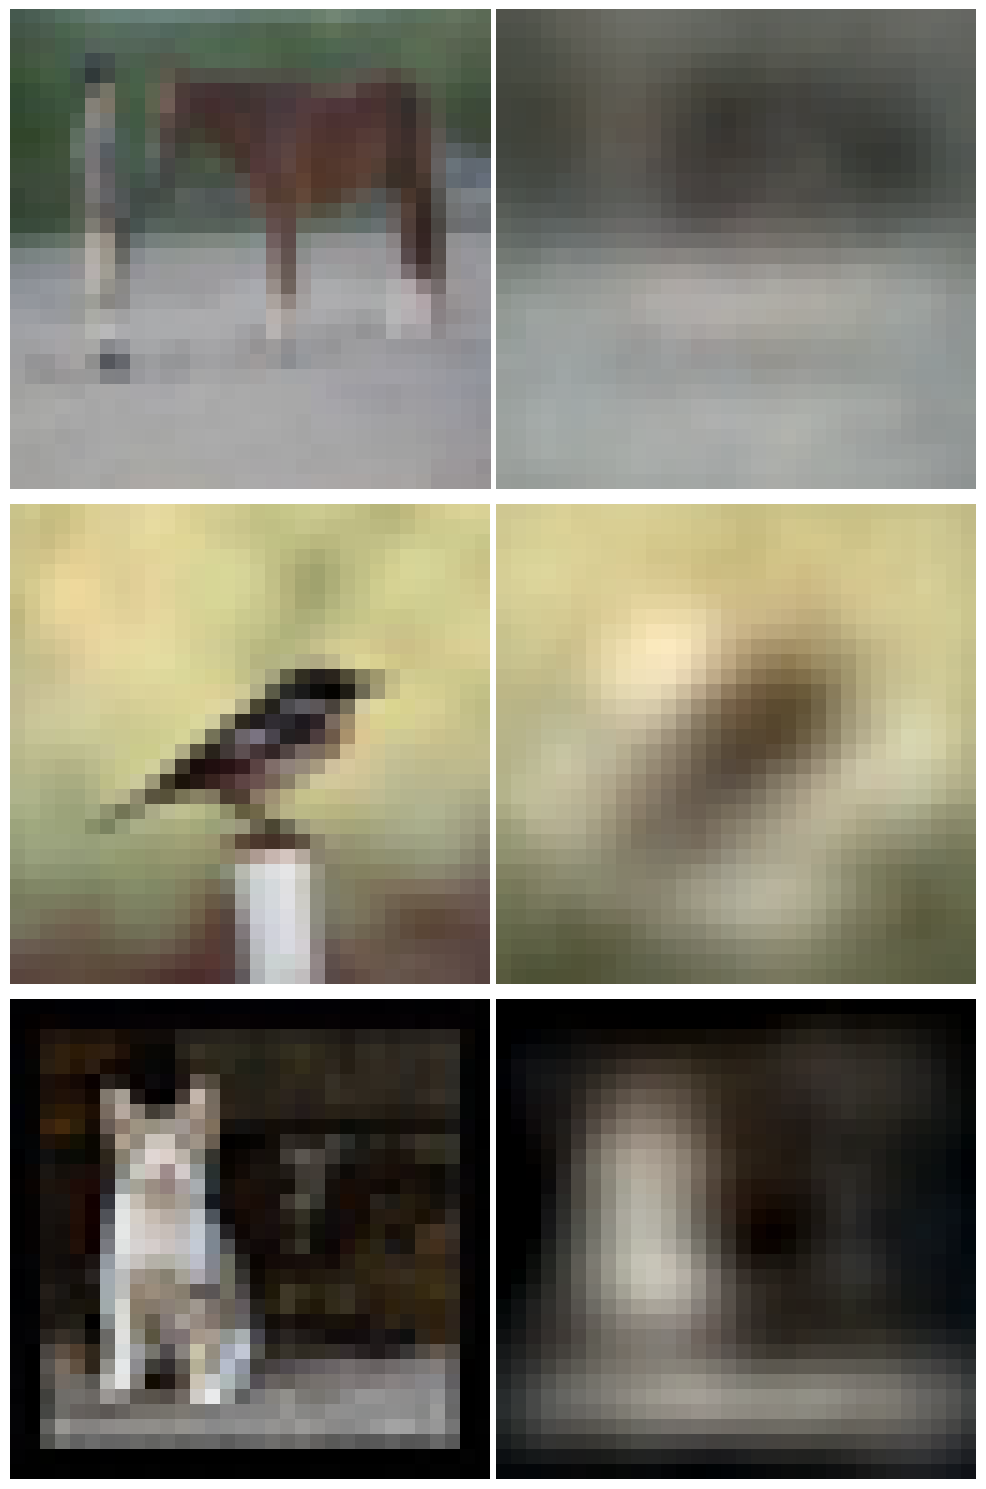

In [28]:
# display 3 random reconstructions from weight-tied model

val_indices = list(range(len(val_subset)))
random_indices = random.sample(val_indices, 3)

images = []
for idx in random_indices:
    img, _ = val_subset[idx]
    images.append(img)

images_batch = torch.stack(images)

transposed_autoencoder.eval()
with torch.no_grad():
    transposed_reconstructions = transposed_autoencoder(images_batch)

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    orig_img = images[i].permute(1, 2, 0).cpu().numpy()
    axes[i, 0].imshow(orig_img.clip(0, 1))
    axes[i, 0].axis('off')

    recon_img = transposed_reconstructions[i].permute(1, 2, 0).cpu().numpy()
    axes[i, 1].imshow(recon_img.clip(0, 1))
    mse = ((images[i] - transposed_reconstructions[i]) ** 2).mean().item()
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

> Is the reconstruction quality better, worse, or roughly the same?

The reconstruction quality looks roughly the same visually, but it's slightly better for the weight-tied model as it achives lower losses (~0.12 vs 0.14 for standard model). Both models produce blurry images that capture general structure but lack fine details.

> If you use the same hyperparameters to train this model and the model from Part 2, is training faster or slower?

Training is slightly faster for the weight-tied model since it has fewer parameters to optimize (due to shared weights), leading to quicker convergence. The weight-tied model takes ~257 seconds while the standard model took ~286 seconds.

> Is this model more or less likely to overfit than the model from Part 2, and why?

The weight-tied model is less likely to overfit compared to the standard model. By sharing weights between the encoder and decoder, the model has fewer parameters, which reduces its capacity to memorize training data. This constraint encourages the model to learn more generalizable features, leading to better performance on unseen data.